Import Library

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.autograd import Variable, grad
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

Load dan Split Dataset

In [2]:
# Membaca dataset dari file CSV
data = pd.read_csv("dataset/merged_data_cleaned_final.csv")

# Memeriksa beberapa baris pertama untuk memastikan data berhasil dimuat
data.head(10)

,ID,PROFESI PEKERJAAN,"Algoritma dan Kompleksitas, Teori Ilmu Komputer, Konsep Bahasa Pemrograman","Arsitektur dan organisasi komputer, jaringan dan komunikasi, sistem operasi, dan komputasi paralel dan terdistribusi",Sistem Cerdas,"Pengolahan Citra, Grafik dan Multimedia",Keamanan Komputer,Ilmu Humaniora
0,Alumni001,INFORMATION SYSTEM AND TECHNOLOGY DEVELOPMENT,3.6,3.6,1.6,3.5,4.0,3.2
1,Alumni002,IT SECURITY AND COMPLIANCE,3.4,3.4,1.9,3.3,4.0,3.8
2,Alumni003,PROGRAMMING AND SOFTWARE DEVELOPMENT,3.3,3.3,1.5,3.5,3.5,3.6
3,Alumni004,DATA MANAGEMENT SYSTEM,3.0,3.1,1.5,2.8,3.0,2.8
4,Alumni005,PROGRAMMING AND SOFTWARE DEVELOPMENT,3.2,3.1,1.9,3.2,4.0,3.4
5,Alumni006,IT PROJECT MANAGEMENT,3.1,3.0,2.0,3.3,4.0,3.0
6,Alumni007,DATA MANAGEMENT SYSTEM,3.2,3.3,1.8,3.0,3.0,3.2
7,Alumni008,NETWORK AND INFRASTRUCTURE,3.1,3.1,1.8,3.0,3.5,3.2
8,Alumni009,IT SECURITY AND COMPLIANCE,3.4,3.3,1.5,2.8,3.5,3.6
9,Alumni010,IT MULTEMEDIA,3.9,3.3,1.5,3.2,4.0,4.0


<Axes: title={'center': 'Distribusi Profesi Pekerjaan Mahasiswa'}, xlabel='PROFESI PEKERJAAN'>

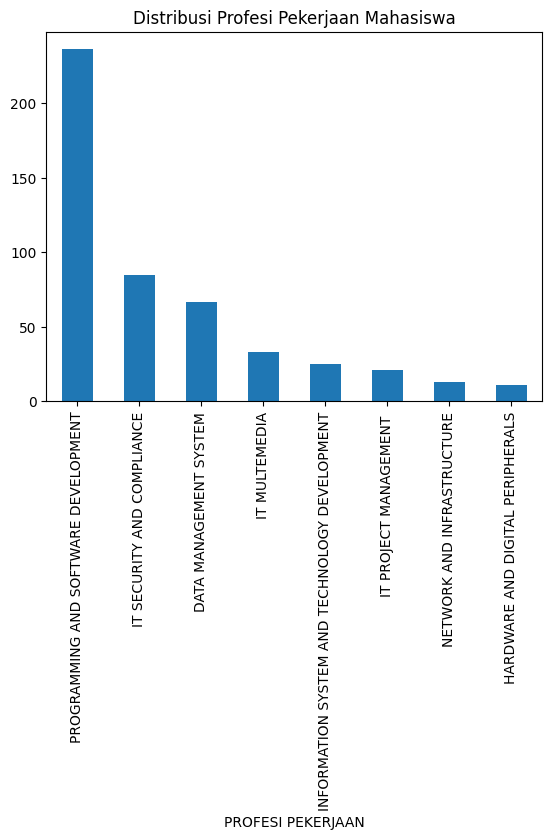

In [4]:
# Cek Profesi Pekerjaan Mahasiswa
distribusi_profesi = data["PROFESI PEKERJAAN"].value_counts()


distribusi_profesi.plot(kind="bar", title="Distribusi Profesi Pekerjaan Mahasiswa")

Definisikan Generator dan Discriminator

In [287]:
class Generator(nn.Module):
    def __init__(self, input_dim, condition_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, output_dim),
            nn.Tanh()
        )

    def forward(self, noise, condition):
        x = torch.cat([noise, condition], 1)
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim, condition_dim, num_classes):
        super(Discriminator, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(14, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2)
        )
        self.real_fake = nn.Linear(128, 1)
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, data, condition):
        x = torch.cat([data, condition], 1)
        features = self.shared(x)
        validity = self.real_fake(features)
        class_pred = self.classifier(features)
        return validity, class_pred


Gradient Penalty Function

In [288]:
def gradient_penalty(discriminator, real_data, fake_data, condition):
    batch_size = real_data.size(0)
    epsilon = torch.rand(batch_size, 1).expand_as(real_data)
    interpolated = epsilon * real_data + (1 - epsilon) * fake_data
    interpolated = Variable(interpolated, requires_grad=True)

    prob_interpolated, _ = discriminator(interpolated, condition)

    gradients = grad(outputs=prob_interpolated, inputs=interpolated,
                     grad_outputs=torch.ones(prob_interpolated.size()),
                     create_graph=True, retain_graph=True)[0]

    gradients = gradients.view(batch_size, -1)
    penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return penalty


In [290]:
# Misalkan kolom yang menyimpan bidang profesi adalah 'bidangprofesi'
# Hitung jumlah data untuk setiap kelas (bidang profesi)
count_per_class = data['PROFESI PEKERJAAN'].value_counts()

# Tampilkan hasil
print(count_per_class)

PROFESI PEKERJAAN
PROGRAMMING AND SOFTWARE DEVELOPMENT             236
IT SECURITY AND COMPLIANCE                        85
DATA MANAGEMENT SYSTEM                            67
IT MULTEMEDIA                                     33
INFORMATION SYSTEM AND TECHNOLOGY DEVELOPMENT     25
IT PROJECT MANAGEMENT                             21
NETWORK AND INFRASTRUCTURE                        13
HARDWARE AND DIGITAL PERIPHERALS                  11
Name: count, dtype: int64


In [291]:
# Menghitung bobot kelas
total_samples = len(data)
num_classes = len(count_per_class)
class_weights = {cls: total_samples / (num_classes * count) for cls, count in count_per_class.items()}

print("Bobot Kelas:", class_weights)

Bobot Kelas: {'PROGRAMMING AND SOFTWARE DEVELOPMENT': 0.2600635593220339, 'IT SECURITY AND COMPLIANCE': 0.7220588235294118, 'DATA MANAGEMENT SYSTEM': 0.9160447761194029, 'IT MULTEMEDIA': 1.8598484848484849, 'INFORMATION SYSTEM AND TECHNOLOGY DEVELOPMENT': 2.455, 'IT PROJECT MANAGEMENT ': 2.9226190476190474, 'NETWORK AND INFRASTRUCTURE': 4.721153846153846, 'HARDWARE AND DIGITAL PERIPHERALS': 5.579545454545454}


In [292]:
# Mengambil kolom bidangilmu1 sampai bidangilmu6 sebagai fitur
X = data[['Algoritma dan Kompleksitas, Teori Ilmu Komputer, Konsep Bahasa Pemrograman', 'Arsitektur dan organisasi komputer, jaringan dan komunikasi, sistem operasi, dan komputasi paralel dan terdistribusi', 'Sistem Cerdas', 'Pengolahan Citra, Grafik dan Multimedia', 'Keamanan Komputer', 'Ilmu Humaniora']].values.astype(float)

# Menggunakan LabelEncoder untuk mengonversi kolom PROFESI PEKERJAAN ke label integer
le = LabelEncoder()
y = le.fit_transform(data['PROFESI PEKERJAAN'])

# Mengonversi ke tensor PyTorch
y = torch.LongTensor(y)

# Mengubah PROFESI PEKERJAAN menjadi one-hot encoding
condition = torch.tensor(pd.get_dummies(data['PROFESI PEKERJAAN']).values).float()

# Split data menjadi training dan testing
X_train, X_test, y_train, y_test, cond_train, cond_test = train_test_split(X, y, condition, test_size=0.3, random_state=42)

# Konversi ke tensor PyTorch
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()

# Buat TensorDataset dan DataLoader
train_dataset = TensorDataset(X_train, cond_train, y_train)
test_dataset = TensorDataset(X_test, cond_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Memeriksa bentuk data
print("Shape X_train:", X_train.shape)
print("Shape y_train:", y_train.shape)
print("Shape condition (train):", cond_train.shape)

Shape X_train: torch.Size([343, 6])
Shape y_train: torch.Size([343])
Shape condition (train): torch.Size([343, 8])


Training Loop

In [ ]:
latent_dim = 100
num_classes = 8
data_dim = 6
lambda_gp = 10

generator = Generator(latent_dim, num_classes, data_dim)
discriminator = Discriminator(data_dim, num_classes, num_classes)

optimizer_G = optim.Adam(generator.parameters(), lr=0.00001, betas=(0.5, 0.9))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.00005, betas=(0.5, 0.9))

# Early Stopping Parameters
patience = 20          # Jumlah epoch tanpa peningkatan sebelum early stopping
min_delta = 0.001      # Perbedaan minimum yang dianggap peningkatan
best_class_loss = float('inf')  # Mulai dengan loss terbaik sebagai tak hingga
early_stop_counter = 0      # Counter untuk early stopping

num_epochs = 10000
for epoch in range(num_epochs):
    for real_data, condition, labels in train_loader:
        batch_size = real_data.size(0)
        real_data, condition, labels = Variable(real_data), Variable(condition), Variable(labels)

        # Step 1: Train Discriminator
        for _ in range(2):  
            noise = Variable(torch.randn(batch_size, latent_dim))
            fake_data = generator(noise, condition).detach()

            d_real, class_real = discriminator(real_data, condition)
            d_fake, _ = discriminator(fake_data, condition)

            gp = gradient_penalty(discriminator, real_data, fake_data, condition)

            d_loss = d_fake.mean() - d_real.mean() + lambda_gp * gp
            class_loss = nn.CrossEntropyLoss()(class_real, labels)

            optimizer_D.zero_grad()
            d_loss.backward(retain_graph=True)
            class_loss.backward()
            optimizer_D.step()

        # Step 2: Train Generator
        target_classes = [1, 2, 4, 6]  # Kelas yang ingin dihasilkan
        num_samples_per_class = 50  # Jumlah sampel yang ingin dihasilkan untuk setiap kelas
        
        for target_class in target_classes:  # Iterasi untuk kelas target
            for _ in range(num_samples_per_class):  # Menghasilkan beberapa sampel untuk setiap kelas
                noise = Variable(torch.randn(batch_size, latent_dim))  # Noise acak
        
                # One-hot encoding untuk kelas target
                condition = torch.eye(num_classes)[target_class].repeat(batch_size, 1)  # one-hot encoding untuk Class 1
        
                fake_data = generator(noise, condition) # Menghasilkan data palsu
        
                # Menghitung loss generator
                g_loss = -discriminator(fake_data, condition)[0].mean()

                # Update model generator
                optimizer_G.zero_grad()
                g_loss.backward()
                optimizer_G.step()
        
    # Early Stopping Check based on Class Loss
    if class_loss.item() < best_class_loss - min_delta:
        best_class_loss = class_loss.item()
        early_stop_counter = 0  # Reset counter jika ada peningkatan
    else:
        early_stop_counter += 1  # Tidak ada peningkatan, tambahkan counter

    if early_stop_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch}")
        break  # Keluar dari loop pelatihan
    
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}] | D Loss: {d_loss.item()} | G Loss: {g_loss.item()} | Class Loss: {class_loss.item()}")
    

Epoch [0/10000] | D Loss: 8.470193862915039 | G Loss: -0.05118333920836449 | Class Loss: 2.0397143363952637
Epoch [10/10000] | D Loss: -5.733538627624512 | G Loss: -2.548042058944702 | Class Loss: 1.6128708124160767
Epoch [20/10000] | D Loss: -6.218935966491699 | G Loss: -2.843599319458008 | Class Loss: 1.7057561874389648
Epoch [30/10000] | D Loss: -6.061505317687988 | G Loss: -2.798456907272339 | Class Loss: 1.462849497795105
Epoch [40/10000] | D Loss: -6.642693996429443 | G Loss: -2.8774962425231934 | Class Loss: 0.9537949562072754
Epoch [50/10000] | D Loss: -6.325874328613281 | G Loss: -2.8628973960876465 | Class Loss: 0.7737310528755188
Epoch [60/10000] | D Loss: -6.349991798400879 | G Loss: -2.85420823097229 | Class Loss: 0.6071338057518005
Epoch [70/10000] | D Loss: -5.905112266540527 | G Loss: -2.866870164871216 | Class Loss: 0.4901111125946045
Epoch [80/10000] | D Loss: -5.868459224700928 | G Loss: -3.000647783279419 | Class Loss: 0.58185875415802
Epoch [90/10000] | D Loss: -6.

In [275]:
def evaluate_real_vs_fake(discriminator, generator, real_data_loader, latent_dim):
    discriminator.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for real_data, condition, _ in real_data_loader:
            batch_size = real_data.size(0)
            
            # Real data label = 1
            real_labels = torch.ones(batch_size)
            real_output, _ = discriminator(real_data, condition)
            real_pred = (real_output > 0.5).float().squeeze()  # Threshold untuk label real
            y_true.extend(real_labels.tolist())
            y_pred.extend(real_pred.tolist())
            
            # Fake data label = 0
            noise = torch.randn(batch_size, latent_dim)
            fake_data = generator(noise, condition)
            fake_labels = torch.zeros(batch_size)
            fake_output, _ = discriminator(fake_data, condition)
            fake_pred = (fake_output > 0.5).float().squeeze()  # Threshold untuk label fake
            y_true.extend(fake_labels.tolist())
            y_pred.extend(fake_pred.tolist())

    # Hitung akurasi
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Discriminator Accuracy (Real vs Fake): {accuracy * 100:.2f}%")

evaluate_real_vs_fake(discriminator, generator, train_loader, latent_dim)


Discriminator Accuracy (Real vs Fake): 50.00%


In [276]:
def evaluate_classification(discriminator, data_loader):
    discriminator.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for real_data, condition, labels in data_loader:
            _, class_output = discriminator(real_data, condition)
            class_pred = torch.argmax(class_output, dim=1)  # Prediksi kelas berdasarkan output max
            y_true.extend(labels.tolist())
            y_pred.extend(class_pred.tolist())

    # Print classification report dengan zero_division=0
    print("Classification Report (Classifying bidangprofesi):")
    print(classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in range(class_output.size(1))], zero_division=0))

evaluate_classification(discriminator, train_loader)

Classification Report (Classifying bidangprofesi):
              precision    recall  f1-score   support

     Class 0       0.79      1.00      0.88        46
     Class 1       0.00      0.00      0.00         8
     Class 2       0.00      0.00      0.00        14
     Class 3       0.55      1.00      0.71        22
     Class 4       1.00      0.29      0.44        14
     Class 5       0.87      1.00      0.93        58
     Class 6       0.00      0.00      0.00         9
     Class 7       0.99      1.00      0.99       172

    accuracy                           0.88       343
   macro avg       0.52      0.54      0.50       343
weighted avg       0.82      0.88      0.84       343



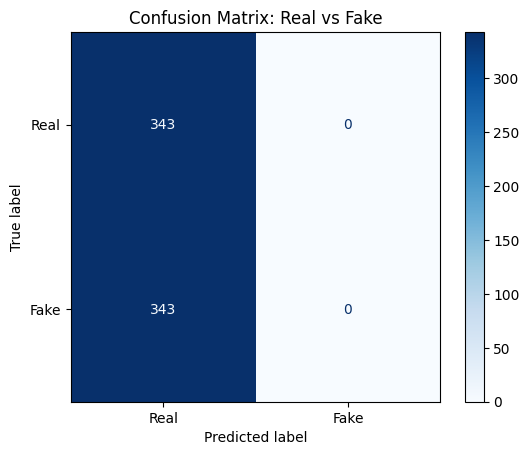

In [277]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_real_vs_fake_confusion(discriminator, generator, real_data_loader, latent_dim):
    discriminator.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for real_data, condition, _ in real_data_loader:
            batch_size = real_data.size(0)
            
            # Real data label = 1
            real_labels = torch.ones(batch_size)
            real_output, _ = discriminator(real_data, condition)
            real_pred = (real_output > 0.5).float().squeeze()  # Threshold untuk label real
            y_true.extend(real_labels.tolist())
            y_pred.extend(real_pred.tolist())
            
            # Fake data label = 0
            noise = torch.randn(batch_size, latent_dim)
            fake_data = generator(noise, condition)
            fake_labels = torch.zeros(batch_size)
            fake_output, _ = discriminator(fake_data, condition)
            fake_pred = (fake_output > 0.5).float().squeeze()  # Threshold untuk label fake
            y_true.extend(fake_labels.tolist())
            y_pred.extend(fake_pred.tolist())

    # Hitung confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix: Real vs Fake")
    plt.show()

evaluate_real_vs_fake_confusion(discriminator, generator, train_loader, latent_dim)


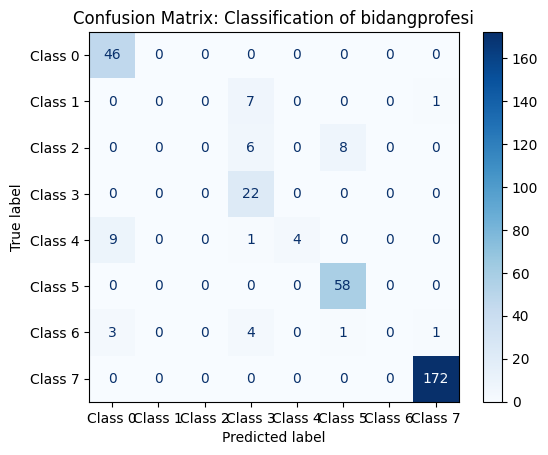

In [278]:
def evaluate_classification_confusion(discriminator, data_loader):
    discriminator.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for real_data, condition, labels in data_loader:
            _, class_output = discriminator(real_data, condition)
            class_pred = torch.argmax(class_output, dim=1)  # Prediksi kelas berdasarkan output max
            y_true.extend(labels.tolist())
            y_pred.extend(class_pred.tolist())

    # Hitung confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in range(cm.shape[0])])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix: Classification of bidangprofesi")
    plt.show()

evaluate_classification_confusion(discriminator, train_loader)


Data Uji

In [279]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Ubah tensor menjadi tipe yang diinginkan menggunakan .clone() atau .detach()
X_test = X_test.clone().float()  # Atau gunakan .detach().float() jika tidak ingin mempertahankan hubungan gradien
y_test = y_test.clone().long()
cond_test = cond_test.clone().float()

# Buat TensorDataset dan DataLoader untuk data uji
test_dataset = TensorDataset(X_test, cond_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [280]:
def evaluate_real_vs_fake_confusion(discriminator, generator, real_data_loader, latent_dim):
    discriminator.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for real_data, condition, _ in real_data_loader:
            batch_size = real_data.size(0)
            
            # Real data label = 1
            real_labels = torch.ones(batch_size)
            real_output, _ = discriminator(real_data, condition)
            real_pred = (real_output > 0.5).float().squeeze()  # Threshold untuk label real
            y_true.extend(real_labels.tolist())
            y_pred.extend(real_pred.tolist())
            
            # Fake data label = 0
            noise = torch.randn(batch_size, latent_dim)
            fake_data = generator(noise, condition)
            fake_labels = torch.zeros(batch_size)
            fake_output, _ = discriminator(fake_data, condition)
            fake_pred = (fake_output > 0.5).float().squeeze()  # Threshold untuk label fake
            y_true.extend(fake_labels.tolist())
            y_pred.extend(fake_pred.tolist())

    # Hitung confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix: Real vs Fake (Test Data)")
    plt.show()


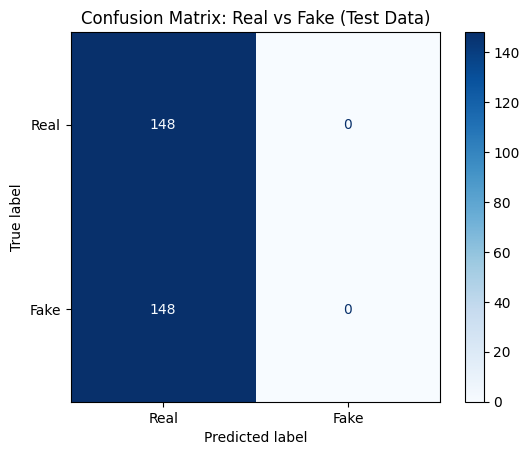

In [281]:
evaluate_real_vs_fake_confusion(discriminator, generator, test_loader, latent_dim)

In [282]:
def evaluate_classification_confusion(discriminator, data_loader):
    discriminator.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for real_data, condition, labels in data_loader:
            _, class_output = discriminator(real_data, condition)
            class_pred = torch.argmax(class_output, dim=1)  # Prediksi kelas berdasarkan output max
            y_true.extend(labels.tolist())
            y_pred.extend(class_pred.tolist())

    # Hitung confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in range(cm.shape[0])])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix: Classification of bidangprofesi (Test Data)")
    plt.show()


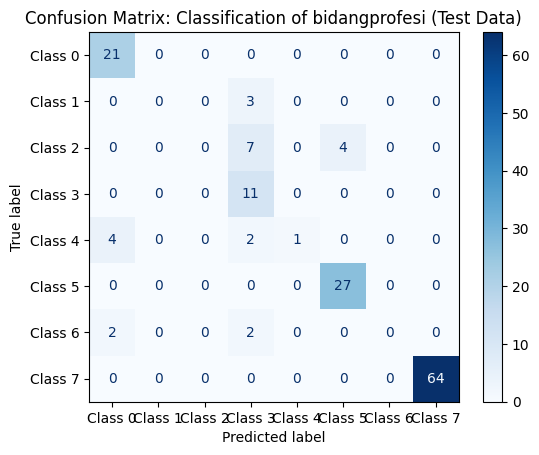

In [283]:
evaluate_classification_confusion(discriminator, test_loader)